# McNemar test for GDF+PCA+MLP vs QUE+LOG

Null-Hypothesis: 
"Under the null hypothesis, the two algorithms should have the same error rate"

(Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithm, 1998)


If pvalue will be small we will reject that null hypothesis.


Beware - columns `TN	FN	FP	TP` are from contingency table, not from confusion table (so not for actual values). "Positives" in that case are the samples for which MLP predicted 1.

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_gdf_pca_mlp_mcnemar'
if_should_savefig = False

In [3]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    if 'mcnemar' in f:
        df_res = df_res.append(pd.read_csv(os.path.join(data_dir, f)))
df_res.index = df_res['stock']
df_res.drop(columns='Unnamed: 0', inplace=True)
df_res

,pvalue,statistic,TN,FN,FP,TP,stock
stock,,,,,,,
4851,3.103237e-06,21.751645,1579,362,246,2612,4851
9058,4.933814e-04,12.140515,1924,250,177,2448,9058
4320,8.194317e-03,6.990506,1866,182,134,2617,4320
3459,1.148244e-46,205.773399,1472,482,127,2718,3459
2822,3.624322e-01,0.829448,1774,421,394,2210,2822
10470,4.987378e-02,3.845697,1830,187,150,2632,10470
9061,1.582943e-01,1.990446,2020,170,144,2465,9061
2748,5.024154e-123,556.430715,1287,964,169,2379,2748
1431,1.809505e-04,14.019231,1822,275,193,2509,1431


In [4]:
df_res[df_res['pvalue'] > 0.1]

,pvalue,statistic,TN,FN,FP,TP,stock
stock,,,,,,,
2822,0.362432,0.829448,1774,421,394,2210,2822
9061,0.158294,1.990446,2020,170,144,2465,9061
4799,0.145610,2.117647,2018,12,5,2764,4799
9062,0.754454,0.097826,2241,48,44,2466,9062
11583,0.319313,0.991758,1898,192,172,2537,11583


In [5]:
list(df_res[df_res['pvalue'] > 0.1].index)

[2822, 9061, 4799, 9062, 11583]

In [6]:
df_res[['pvalue', 'statistic']].describe()

,pvalue,statistic
count,1.500000e+01,15.000000
mean,1.199565e-01,60.587016
std,2.130543e-01,146.505308
min,5.024154e-123,0.097826
25%,1.665328e-06,2.054046
50%,4.980013e-04,12.123134
75%,1.519522e-01,24.268227
max,7.544542e-01,556.430715


In [7]:
print(df_res[['pvalue', 'statistic']].describe().to_latex())

\begin{tabular}{lrr}
\toprule
{} &         pvalue &   statistic \\
\midrule
count &   1.500000e+01 &   15.000000 \\
mean  &   1.199565e-01 &   60.587016 \\
std   &   2.130543e-01 &  146.505308 \\
min   &  5.024154e-123 &    0.097826 \\
25\%   &   1.665328e-06 &    2.054046 \\
50\%   &   4.980013e-04 &   12.123134 \\
75\%   &   1.519522e-01 &   24.268227 \\
max   &   7.544542e-01 &  556.430715 \\
\bottomrule
\end{tabular}



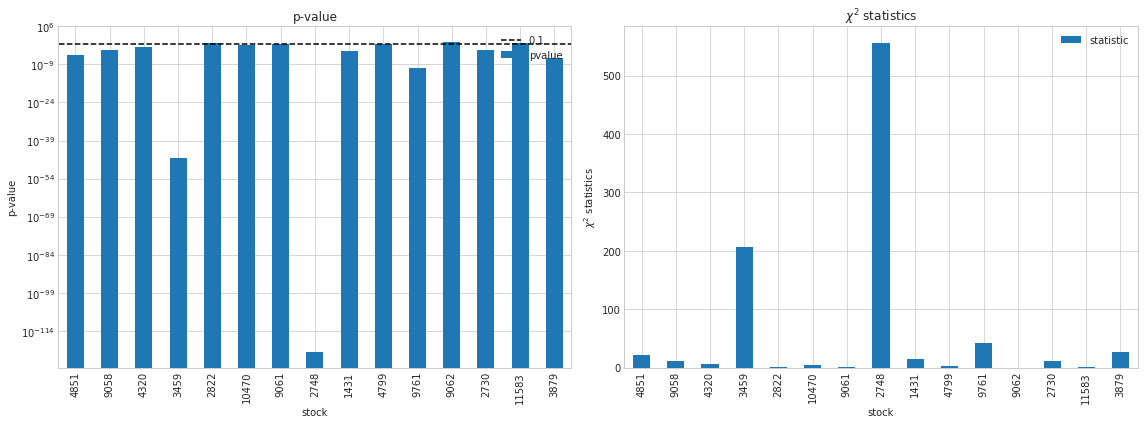

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_res[['pvalue']].plot(kind='bar', ax=ax1)
ax1.hlines(y=0.1, xmin=-10, xmax=100, linestyle='--', label='0.1')
ax1.set_title('p-value')
ax1.set_ylabel('p-value')
ax1.set_yscale('log')


ax1.legend()

df_res[['statistic']].plot(kind='bar', ax=ax2)
ax2.set_title('$\chi^2$ statistics')
ax2.set_ylabel('$\chi^2$ statistics')
ax2.legend()
plt.tight_layout()
if if_should_savefig:
    plt.savefig('MLP_log_mcnemar.png')

## Conclusion

For five stocks the $p$-value is above the treshold, but for the rest of the stocks we can reject Null Hypothesis. 